In [54]:
#-*- coding:utf8-*-
%matplotlib inline

from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import Image

import numpy as np

import uncertainties as unc
from uncertainties import unumpy as unp
from uncertainties.unumpy import std_devs as stds #TODO
from uncertainties.unumpy import nominal_values as noms #TODO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D 

import seaborn as sns
sns.set(context="paper",font_scale=1.4)
colors = sns.color_palette()

import scipy as sp
import scipy.constants as const

import sympy as sym

import pandas as pd

#import ROOT as rt

#import root_numpy as rnp

#from aputils.latextables.tables import Table


# Fehlerfortpflanzung beim Mitteln
umean = unc.wrap(np.mean)

#Laden des Latex fonts 
plt.rcParams['text.latex.preamble']=["\\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

#Größe der Achsenbeschriftung
axis_font = {'size':'14'}

# Pfade
path_graphics = "../Grafiken/"
path_table = "../Tabellen/"
path_data = "../Messdaten/"

In [60]:
# Funktionen
# Achsenbeschriftungen
def axis_label(label,sym=None,unit=None):
    if sym == None:
        return lable
    elif unit == None:
        return r"".join([label," ${s}$".format(s=sym)])
    else:
        return r"".join([label," ${s}/\mathrm{{{u}}}$".format(s=sym,u=unit)])

# Achsenskalierung
def axis_scale(factor, ax=None, axis="x"):
    if ax is None:
        ax = plt.gca()
    if axis == "x":
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    elif axis == "y":
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    else:
        print("Wrong axis name given! Only x and y are allowed!")

def siunitx_ticklabels(ax=None, locale="DE", xaxis=True, yaxis=True,
                       round_precision=2, round_mode="places", scale_x=None, scale_y=None):
    """
    This function uses siunitx to create the ticklabels
    Main reason is for adjusting the decimal marker properly.
    The function takes 4 arguments:
        ax=None     the matplotlib axes to operate on
                    if set to None (Standard) this will be the current axes
        locale="DE" The locale parameter for siunitx, one of
                    "UK", "US", "DE", "FR" oder "ZA"
        xaxis=True  Boolean, if True the labels for the xaxis are set
        yaxis=True  Boolean, if True the labels for the yaxis are set
        round_precision=2 Number of places or figures after rounding
        round_mode="places" Rounds to round_precision many decimal places,
                  "figures" Rounds to round_precision many significant figures
                  
    """

    if ax is None:
        ax = plt.gca()

    if scale_x == None:
        scale_x = 1
    if scale_y == None:
        scale_y = 1
        
        
    if xaxis is True:
        xticks = ax.get_xticks()
        print(xticks)
        xlabels = [r"$\num[locale={},round-mode={},round-precision={}]{{{}}}$".format(
                   locale, round_mode,round_precision, tick*scale_x) for tick in xticks]
        #print(xlabels)
        ax.set_xticklabels(xlabels)

    if yaxis is True:
        yticks = ax.get_yticks()
        ylabels = [r"$\num[locale={},round-mode={},round-precision={}]{{{}}}$".format(
                   locale, round_mode,round_precision, tick*scale_y) for tick in yticks]
        #print(ylabels)
        ax.set_yticklabels(ylabels)    
        
        
def errorbar(x,y,marker="o",linestyle="",color=None, ax=None,label="", factor_x=1, factor_y=1):
    if ax is None:
        ax = plt.gca()
    ax.errorbar(noms(x),noms(y), xerr=stds(x)*factor_x, yerr=stds(y)*factor_y,
                color=color, marker=marker, linestyle=linestyle,label=label)
    

# Fit Funktionen
def fit_errors(popt,pcov):
    errors = np.sqrt(np.diag(pcov))
    param_err = unp.uarray(popt,errors)
    return param_err
    
def print_errors(array,description=None):
    if description and len(description)==len(array):
        maxlen = max(map(len,description))
        lens = list(map(len,description))
        for i,entry in enumerate(array):
            print(description[i]," "*(maxlen-lens[i]),entry.nominal_value,"+/-",entry.std_dev)
    else:
        for i,entry in enumerate(array):
            print(entry.nominal_value,"+/-",entry.std_dev)

def save_results(value,unit,file):
    significant_figure = abs(int(np.log10(stds(value))))
    std = int(np.round(stds(value),significant_figure)*10**significant_figure)
    
    siuntix_string = "\\SI{{{v}({s})}}{{{u}}}".format(v=np.round(noms(value),significant_figure),s=std,u=unit)
    with open(path_results+file,"w") as f:
        print(siuntix_string, file=f)

## Hysterese des Magnetfelds

### Laden der Messfehler

In [16]:
uncertainties = pd.read_csv(path_data+"Messfehler.csv")

In [17]:
uncertainties.head()

,Strom I/A,Magnetfeld B/mT
0,0.5,1


### Laden der Messwerte

#### Erste Messreihe


In [23]:
hysteresis_1 = pd.read_csv(path_data+"Hysterese_Magnetfeld_I.csv")

In [24]:
hysteresis_1.head()

,Strom I/A,Magnetfeld (I zunehmend) B/mT,Magnetfeld (I abnehmend) B/mT
0,0,6,8
1,1,72,75
2,2,136,144
3,3,189,202
4,4,248,261


In [25]:
# Erzeugung fehlerbehafteter Messwerte
hysteresis_1["Strom I/A"] = unp.uarray(hysteresis_1["Strom I/A"].values,
                                       uncertainties["Strom I/A"].values)
hysteresis_1["Magnetfeld (I zunehmend) B/mT"] = unp.uarray(hysteresis_1["Magnetfeld (I zunehmend) B/mT"].values,
                                                           uncertainties["Magnetfeld B/mT"].values)
hysteresis_1["Magnetfeld (I abnehmend) B/mT"] = unp.uarray(hysteresis_1["Magnetfeld (I abnehmend) B/mT"].values,
                                                           uncertainties["Magnetfeld B/mT"].values)

In [26]:
hysteresis_1.head()

,Strom I/A,Magnetfeld (I zunehmend) B/mT,Magnetfeld (I abnehmend) B/mT
0,0.0+/-0.5,6.0+/-1.0,8.0+/-1.0
1,1.0+/-0.5,72.0+/-1.0,75.0+/-1.0
2,2.0+/-0.5,136.0+/-1.0,144.0+/-1.0
3,3.0+/-0.5,189.0+/-1.0,202.0+/-1.0
4,4.0+/-0.5,248.0+/-1.0,261.0+/-1.0


#### Zweite Messreihe

In [27]:
hysteresis_2 = pd.read_csv(path_data+"Hysterese_Magnetfeld_II.csv")

In [28]:
hysteresis_2.head()

,Strom I/A,Magnetfeld (I zunehmend) B/mT,Magnetfeld (I abnehmend) B/mT
0,0,5,7
1,1,80,59
2,2,150,141
3,3,218,209
4,4,286,284


In [29]:
# Erzeugung fehlerbehafteter Messwerte
hysteresis_2["Strom I/A"] = unp.uarray(hysteresis_2["Strom I/A"].values,
                                       uncertainties["Strom I/A"].values)
hysteresis_2["Magnetfeld (I zunehmend) B/mT"] = unp.uarray(hysteresis_2["Magnetfeld (I zunehmend) B/mT"].values,
                                                           uncertainties["Magnetfeld B/mT"].values)
hysteresis_2["Magnetfeld (I abnehmend) B/mT"] = unp.uarray(hysteresis_2["Magnetfeld (I abnehmend) B/mT"].values,
                                                           uncertainties["Magnetfeld B/mT"].values)

In [31]:
hysteresis_2.head()

,Strom I/A,Magnetfeld (I zunehmend) B/mT,Magnetfeld (I abnehmend) B/mT
0,0.0+/-0.5,5.0+/-1.0,7.0+/-1.0
1,1.0+/-0.5,80.0+/-1.0,59.0+/-1.0
2,2.0+/-0.5,150.0+/-1.0,141.0+/-1.0
3,3.0+/-0.5,218.0+/-1.0,209.0+/-1.0
4,4.0+/-0.5,286.0+/-1.0,284.0+/-1.0


### Plots der Hysterese


#### Erste Messung

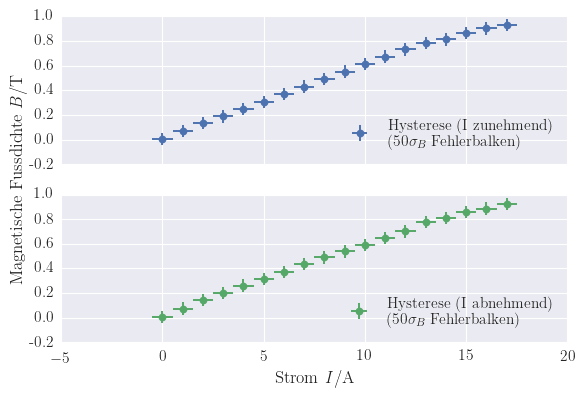

In [72]:
fig, axes = plt.subplots(nrows=2, sharex=True)
ax_upper, ax_lower = np.ravel(axes)

ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.grid(False)

ax_lower.set_xlabel(axis_label("Strom","I","A"))

axis_scale(1e-3, ax=ax_upper, axis="y")
axis_scale(1e-3, ax=ax_lower, axis="y")
ax.set_ylabel(axis_label("Magnetische Fussdichte","B","T"))




errorbar(hysteresis_1["Strom I/A"],
         hysteresis_1["Magnetfeld (I zunehmend) B/mT"], factor_y = 50, color=colors[0],
         ax=ax_upper, label="Hysterese (I zunehmend)\n(50$\sigma_{B}$ Fehlerbalken)")

errorbar(hysteresis_1["Strom I/A"],
         hysteresis_1["Magnetfeld (I abnehmend) B/mT"], factor_y = 50, color=colors[1],
         ax=ax_lower, label="Hysterese (I abnehmend)\n(50$\sigma_{B}$ Fehlerbalken)")


ax_upper.legend(loc="lower right")
ax_lower.legend(loc="lower right")
plt.tight_layout()
fig.savefig(path_graphics+"Hysterese_Messung_I.pdf")

In [46]:
plt.twiny?
